# Finding An Electron Discriminator for the Track-Trigger

## Abstract

**[MVA](https://en.wikipedia.org/wiki/Multivariate_analysis) discriminators with varying training samples, features, and types are compared by their ability to discriminate between electrons and fake tracks for the track-trigger.**
[The L1 trigger](https://arxiv.org/pdf/1609.02366.pdf) is a CMS detector component that reduces the rate of collision event data output by deciding which events are "interesting" using a coarse picture of the data.
The track-trigger is a proposed upgrade to provide information from the [tracker](http://cms.cern/detector/identifying-tracks) to the L1, which it doesn't have access to currently.
For each track, the track-trigger sends a "track word" containing, among other track data, MVA-processed data to assist the L1 in identifying fake tracks.
A portion of this track word is devoted to electron-specific MVA output.
19 discriminators were tested on samples of electrons and fakes, and discriminators' accuracies were looked at holistically and by pT regions.
Out of the 19 discriminators, it was found that the most performant electron-specific discriminator for the track-trigger is **trained specifically on electrons**, **includes new dimensionally reduced (or "split") chi2 variables in training and testing**, and **is a machine learning model rather than a simple cut.**
Discriminators restricted to higher pT ranges perform better on those ranges, and a pT cut for training should be considered in accordance with the value placed on tracks above some pT cut.

## Introduction

For a quick introduction to machine learning in the track-trigger, check out [the README for this repository](https://github.com/cqpancoast/cms-tracktrigger-ml/blob/master/README.md).

### Goal

The goal is to find the discriminator that labels electrons and fakes most accurately, given four degrees of freedom.
- *Discriminator type*: **[ cuts, gradient boosted decision tree, neural network ]**.
  - Cuts are sets of selections of ranges of track property values, e.g. "pT > 8 GeV", "bendchi2 < 2".
    They are the simplest kind of discriminator.
  - Two other machine learning-based discriminators ("models" from here on out) are considered.
- *Dataset trained on*: **[ electron-specific, general ]**.
  - Was the model trained to discriminate all tracks from fakes, or only electrons?
    Training sets for these are discussed below.
  - Only relevant for models.
- *Train dataset pT range*: **[ all pT values, only pT >= 20 GeV ]**
  - Was the model trained to discriminate tracks of all pTs from all sets of fakes, or only tracks above 20 GeV from fakes above 20 GeV?
  - Also only relevant for models.
- *Track properties trained on*: a set of common track properties and **[ chi2, chi2rphi and chi2rz ]**.
  - The track properties that were common between the models were **[ bendchi2, number of stubs, number of stubs missing from PS layers ]**
  - chi2rphi and chi2rz (LaTeX being ignored in everything but the abstract) are called "split chi2" variables.
    More on them below.
    
The question of resource use in hardware instantiations of these models is ignored.

### Why are the new "split chi2" variables useful for electron identification?

#### Well, what are they?

The chi2 variables here represent how well the stubs of a track line up with those of an ideal track, given the track's parameters. As you might guess from the name, chi2rphi is the component of chi2 in the r-phi plane of the detector, while chi2rz is the component in the r-z plane. More information about these variables can be found in [the slideshow presentation in this repository](split_chi2.pdf).

#### And what about the electrons?

As electrons have low mass, their interactions with the detector will bend their tracks. This causes their stubs to have a high chi2, and will often cause electrons to be mistaken for fake tracks. However, this "bouncing" only occurs in the r-phi plane, meaning that chi2rz-based predictions are much less likely to mistake electrons for fake tracks. So, let's see what machine learning has to say about that.

### Electron-Specific vs. General Discriminators

The track word (again, see the README) has a reserved section for other track quality MVA's in addition to the general track quality MVA.
These reserved bits can carry electron-specific and displaced-specific information.

However, if a general model can perform as well on electrons as an electron-specific, then we no longer need additional electron-specific information, and have freed up space in the track word!
Therefore, the hope is that the general model will perform as well as the electron-specific one, although this is unlikely.

### Methods and Metrics

#### Discriminator I/O

19 unique discriminators were created.
Not 24, as you might think from the apparently 2 x 2 x 2 x 3 search space above - cuts do not require a training dataset.

A discriminator is something that takes in information about a track and returns a number between zero and one.
The closer to zero the prediction, the more fake the discriminator thinks the track is, and the analogous case is true for predictions closer to value one and real tracks.
Cut discriminators are truly binary, and only output zero or one.

The track properties that a discriminator took in were **bendchi2**, **the number of stubs**, **the number of stubs missing from PS layers**, and then either **chi2** or **chi2rphi and chi2rz** depending on the discriminator.

The track property that each discriminator attempted to predict was **genuine**.

#### Model Hyperparameters

Hyperparameters for models (e.g., layers and their sizes in a neural network, maximum depth in a boosted decision tree) were chosed based on previous work by Claire Savard.

#### Test Datasets

Two test datasets were used to test how accurately the discriminator predicted `genuine` from other track properties:
- *ZEE test dataset*: Electrons from a ZEE sample, and fakes from a mix of ZEE, ZMM, and QCD samples.
- *SingleEl test dataset*: Electrons from a SingleEl sample, and fakes from a mix of ZEE, ZMM, and QCD samples.

#### Metrics

The success of a discriminator at correctly identifying electrons was its **True Positive Rate**, or **TPR**, while its erroneous classification of fake tracks as electrons was its **False Positive Rate**, or **FPR**.
TPR and FPR can be calculated directly for cuts, but model predictions are probablistic, so a threshold value between zero and one has to be applied first.

Using TPR and FPR, discriminator performance was evaluated in two ways:

- *Area under ROC curves*: a ROC curve is a path through TPR/FPR space parameterized by a changing probablistic threshold applied to a set of probablistic model predictions.
  Roughly, the greater the area under the curve is, the higher TPR and lower FPR one has for the full spectrum of threshold values.
  
- *TPR and FPR by pT*: basically, is the discriminator wildly making cuts against a particular pT region?
  This characteristic makes a discriminator less desirable.

#### Code and Packages

Code-sei of the code here is run using the `ntupledicts` package, which can be found [here](https://github.com/cqpancoast/ntupledicts), along with a simple tutorial that covers all code used.

A few pieces from the `matplotlib.pyplot` package are used as well.

---

In [1]:
# Import everything from ntupledicts except plotting modules.
from ntupledicts import load as ndload
from ntupledicts import operations as ndops
from ntupledicts import analyze as ndanl
from ntupledicts.operations import select as sel
from ntupledicts.ml import data as ndmldata
from ntupledicts.ml import predict as ndmlpred
from ntupledicts.ml import models as ndmlmodels

In [2]:
# Set randomness seed to use throughout study.
random_seed = 42

## Data Acquisition

Grab tracks from stored ntuples, perform cuts, process into datasets.

Four datasets are created:
- A *general sample* using `D49_ZEE`, `D49_ZMM`, and `D49_QCD`, which randomly cuts the number of real tracks down to the number of fakes.
- An *electron-specific sample* using only `D49_ZEE` that selects only electrons, and then cuts down the number of fake tracks to the number of electrons.
- The other two datasets are versions of these two datasets restricted to `pT > 20 GeV`, as much of the interesting physics analysis will take place above that threshold.

### Load All Data From `.root` Files

This may take a few minutes — the author of `ntupledicts` has not yet taken a course in algorithms at the time of writing.
Thankfully, this study is a Jupyter Notebook.

In [3]:
# List the root files we want ntuples from
input_files = ["eventsets/D49_ZEE.root", "eventsets/D49_ZMM.root", "eventsets/D49_QCD.root"]

# What track properties do we want available to play with?
# We can select out which ones we want our models to train on later
track_properties = ["pt", "eta", "z0", "nstub", "hitpattern",
                    "chi2", "bendchi2", "chi2rphi", "chi2rz",
                    "matchtp_pdgid", "genuine", "loose"]
properties_by_track_type = {"trk": track_properties}

# Create ntuple dict from input files
ntuple_dict = ndload.root_files_to_ntuple_dict(input_files, properties_by_track_type)

### Define Selectors

`ntupledicts` uses "selectors" to perform cuts on tracks.
For convenience, there are defined together here, along with the appropriate track property to act on.

In [4]:
electron_sel = sel([sel(11), sel(-11)])  # matchtp_pdgid: selects electrons and antielectrons
not_gen_sel = sel(0)                     # genuine: selects not genuine tracks; or genuine == 0
genuine_sel = sel(1)                     # genuine: selects genuine tracks; or genuine == 1
pt_gt_20_sel = sel(20, float("inf"))     # pt: selects tracks with pT >= 20 GeV

### Get not genuine tracks

In [5]:
# Find all not genuine tracks, with all pTs and with pT > 20 GeV.
# This takes a while, and so is performed for both datasets.
trk_not_gens = ndops.cut_track_prop_dict(ntuple_dict["trk"], {"genuine": not_gen_sel})
print(f"Number of not genuine tracks: {ndops.track_prop_dict_length(trk_not_gens)}")

trk_not_gens_pt20 = ndops.cut_track_prop_dict(trk_not_gens, {"pt": pt_gt_20_sel})
print(f"Number of not genuine tracks with pT > 20 GeV: {ndops.track_prop_dict_length(trk_not_gens_pt20)}")

Number of not genuine tracks: 301548
Number of not genuine tracks with pT > 20 GeV: 36359


### Make Electron-Specific Datasets

In [6]:
# Get genuine electron tracks.
trk_els = ndops.cut_track_prop_dict(ntuple_dict["trk"],
                                    {"matchtp_pdgid": electron_sel, "genuine": genuine_sel})
print(f"Number of electron tracks: {ndops.track_prop_dict_length(trk_els)}")

# Now, add in an equal number of fake tracks and shuffle the track properties dict.
# There are more non-genuines than electrons, so the non-genuines are cut down to size in mix_track_prop_dicts.
el_spec_tpd = ndops.mix_track_prop_dicts([trk_els, trk_not_gens], seed=random_seed)

Number of electron tracks: 55207


In [7]:
# Now make a dataset from the previous one composed of only pt > 20 GeV tracks.
trk_els_pt20 = ndops.cut_track_prop_dict(trk_els, {"pt": pt_gt_20_sel})
print(f"Number of electron tracks with pT > 20 GeV: {ndops.track_prop_dict_length(trk_els_pt20)}")

# Again, add them together and shuffle the track properties dict.
# There are still more non-genuines than genuines, so the non-genuines are cut down to size.
el_spec_pt20_tpd = ndops.mix_track_prop_dicts([trk_els_pt20, trk_not_gens_pt20], seed=random_seed)

Number of electron tracks with pT > 20 GeV: 8758


### Make General (All Tracks) Datasets

In [8]:
# Test general track classifier: simply cut down number of reals to number of fakes.
trk_gens = ndops.cut_track_prop_dict(ntuple_dict["trk"], {"genuine": genuine_sel})
print(f"Number of genuine tracks: {ndops.track_prop_dict_length(trk_gens)}")

# Cut genuines down to not genuine size, add together, and shuffle.
general_tpd = ndops.mix_track_prop_dicts([trk_gens, trk_not_gens], seed=random_seed)

Number of genuine tracks: 3721911


In [9]:
# Now make a dataset from the previous one composed of only pt > 20 GeV tracks.
trk_gens_pt20 = ndops.cut_track_prop_dict(trk_gens, {"pt": pt_gt_20_sel})
print(f"Number of genuine tracks with pT > 20 GeV: {ndops.track_prop_dict_length(trk_gens_pt20)}")

# Again, add them together and shuffle the track properties dict.
# There are still more genuines than non-genuines, so the genuines are cut down to size.
general_pt20_tpd = ndops.mix_track_prop_dicts([trk_gens_pt20, trk_not_gens_pt20], seed=random_seed)

Number of genuine tracks with pT > 20 GeV: 51616


We'll want to act on these track property dictionaries together, so we put them into a dictionary.

In [10]:
track_prop_dicts = {"el_spec": el_spec_tpd,
                    "el_spec_pt20": el_spec_pt20_tpd,
                    "general": general_tpd,
                    "general_pt20": general_pt20_tpd}
train_dataset_names = list(track_prop_dicts.keys())

### Add Stub-Based Track Properties

Use hitpattern and eta to determine how many missing PS stubs there are for each track.
See `ntupledicts.analyze` for documentation.

In [11]:
# Count layers meeting these conditions for each track.
missing_PS_layer = lambda expected, hit, ps: ps and expected and not hit

for dataset_name in track_prop_dicts.keys():
    track_prop_dicts[dataset_name]["missingPS"] = ndanl.create_stub_info_list(
                                                        track_prop_dicts[dataset_name],
                                                        ndanl.basic_process_stub_info(missing_PS_layer))

### Process into Datasets

Process the track prop dicts above into `TrackPropertiesDataset`s.

In [12]:
common_track_props = ["bendchi2", "nstub", "missingPS"]  
    # Track properties that all sets of models will use.
label_property = "genuine"  # What property are we trying to predict?
split_list = [.7, .2, .1]   # How many datasets should we create, and with what relative sizes?

datasets = {}
for dataset_name, track_prop_dict in track_prop_dicts.items():
    datasets[dataset_name] = {}
    datasets[dataset_name]["train"], datasets[dataset_name]["eval"], datasets[dataset_name]["test"] =\
        ndmldata.TrackPropertiesDataset(track_prop_dict,
                                        label_property,
                                        common_track_props).split(split_list)

## Making Discriminators

Counting everything up, it looks like we're going to have a whopping 24 discriminators, one for each permutation of the below:
- *Dataset trained on*: **[ electron-specific, general ]** (models only)
- *Train dataset pT range*: **[ all pT values, only pT >= 20 GeV ]** (models only)
- *Track properties trained on*: common track properties above, and **[ chi2, chi2rphi and chi2rz ]**
  - Note that the training properties above don't include pT.
    Models trained on pT are found to discriminate too heavily against lower tracks.
- *Discriminator type*: **[ simple cuts, gradient boosted decision tree, neural network ]**

We actually only have 19, as cuts are mostly training-dataset agnostic, but this is largely ignored for simplicity's sake.

### A Look at Some Confusing Variables

#### `discriminators`

All discriminators are going to be stored in a dictionary called `discriminators`.
To make things clear, this is a dictionary from **discriminator type** to **train dataset name** (including both electron vs. general and pt all vs. 20 info) to **discriminator set**, which indicates the track properties that were available for a discriminator to use.

Here are the values those keys will be able to take by the end of model creation:
- **discriminator type**: [ `"NN"`, `"GBDT"`, `"cut"` ]
- **train dataset name**: [ `"el_spec"`, `"el_spec_pt20"`, `"general"`, `"general_pt20"` ]
- **discriminator set**: [ `"chi2"`, `"split_chi2"` ]

#### `datasets`

All datasets are already stored in a dictionary called `datasets`.
This is a dictionary from **train dataset name** to **dataset type** to dataset.

Here are the values those keys are able to take:
- **train dataset name**: same as above, so [ `"el_spec"`, `"el_spec_pt20"`, `"general"`, `"general_pt20"` ]
- **dataset type**: [ `"train"`, `"eval"`, `"test"` ]

### Predictive Models

In [13]:
# A map from the names of the model sets to the properties they have in addition to the common properties.
model_sets_dict = {"chi2": ["chi2"], "split_chi2": ["chi2rz", "chi2rphi"]}
model_set_names = list(model_sets_dict.keys())

In [14]:
# Make our models and predictive cuts
discriminators = {"NN": {}, "GBDT": {}}  # cuts will be set later
for dataset_name, tp_datasets in datasets.items():  # iterate through train datasets
    discriminators["NN"][dataset_name] = {}
    discriminators["GBDT"][dataset_name] = {}
    
    for model_set_name, model_set_track_props in model_sets_dict.items():  # iterate through model sets

        # Set dataset active properties to common and set-specific properties
        for dataset_type in tp_datasets.keys():  # iterate through train, eval, test
            tp_datasets[dataset_type].set_active_data_properties(common_track_props + model_set_track_props)

        print("\n")
        print(f"Now training models of set '{model_set_name}' using dataset '{dataset_name}'"
              f"and set-specific properties {model_set_track_props}")

        discriminators["NN"][dataset_name][model_set_name] = ndmlmodels.make_neuralnet(tp_datasets["train"],
                                                                                       eval_dataset=tp_datasets["eval"],
                                                                                       hidden_layers=[6, 4],
                                                                                       epochs=3)
        discriminators["GBDT"][dataset_name][model_set_name] = ndmlmodels.make_gbdt(tp_datasets["train"])



Now training models of set 'chi2' using dataset 'el_spec' and set-specific properties ['chi2'].
Epoch 1/3
25754/25753 [==============================] - 33s 1ms/step - loss: 0.5051 - accuracy: 0.7481 - val_loss: 0.4903 - val_accuracy: 0.7580
Epoch 2/3
25754/25753 [==============================] - 32s 1ms/step - loss: 0.4950 - accuracy: 0.7532 - val_loss: 0.4926 - val_accuracy: 0.7551
Epoch 3/3
25754/25753 [==============================] - 33s 1ms/step - loss: 0.4944 - accuracy: 0.7532 - val_loss: 0.4973 - val_accuracy: 0.7492


Now training models of set 'split_chi2' using dataset 'el_spec' and set-specific properties ['chi2rz', 'chi2rphi'].
Epoch 1/3
25754/25753 [==============================] - 35s 1ms/step - loss: 0.4513 - accuracy: 0.7870 - val_loss: 0.4356 - val_accuracy: 0.7997
Epoch 2/3
25754/25753 [==============================] - 34s 1ms/step - loss: 0.4340 - accuracy: 0.7973 - val_loss: 0.4378 - val_accuracy: 0.7971
Epoch 3/3
25754/25753 [==============================]

### Predictive Cuts

These cuts were simply chosen by trial and error, seeing what produced the points on the ROC curves below with the highest true positive rate and lowest false positive rate.

In [15]:
# Define predictive cuts in the same form as the model dictionaries
chi2_cuts = {"chi2": sel(0, 20), "bendchi2": sel(0, 2)}
el_spec_split_chi2_cuts = {"chi2rz": sel(0, 1), "bendchi2": sel(0, 2)}
    # Chi2rz cuts perform much better for electrons than chi2rphi
general_split_chi2_cuts = {"chi2rphi": sel(0, 20), "chi2rz": sel(0, 1), "bendchi2": sel(0, 2)}

el_spec_cut_set = {"chi2": chi2_cuts, "split_chi2": el_spec_split_chi2_cuts}
general_cut_set = {"chi2": chi2_cuts, "split_chi2": general_split_chi2_cuts}

discriminators["cut"] = {"el_spec": el_spec_cut_set,
                         "el_spec_pt20": el_spec_cut_set,
                         "general": general_cut_set,
                         "general_pt20": general_cut_set}

## Discriminator Predictions

Create two test datasets: `zee_test_ds` and `single_el_test_ds`.
Both are made up of an even number of electrons and fake tracks.

The former is made up of tracks rom the ZEE sample that were not trained on, and the latter is made up of electrontracks from a SingleEl sample with a flat pT distribution from 2 to 100 GeV. Note that while the electron distribution for the first will be different than for the second, their fake distribution will be the same.

All 24 discriminators will store their predictions of the tracks in the datasets themselves, accessible by a unique discriminator key.

### More Confusing Variables

#### `zee_test_ds` and  `single_el_test_ds`

*Type: `ndmldata.TrackPropertiesDict`*

`zee_test_ds` is simply `datasets["el_spec"]["test"]`, which seems weird, but hear me out.
We choose this to store predictions because `datasets["el_spec"]["test"]` is the largest dataset from the trained-on samples that has an equal proportion of electrons and fakes with a non-restricted pT distribution.
That is, it has the form of the data we want — *now we can use models trained from other datasets to make predictions on this one*.

`single_el_test_ds` will have the same predictions as `zee_test_ds`, except the tracks that it stores are a mix of a SingleEl sample (flat pT, 2 to 100) and a random set of fakes from the ZEE root samples.
**This is critical, as we can evaluate performance of the models on a less biased electron pT distribution.** Note that the fake tracks will still have a non-flat pT distribution.

Both datasets will store predictions from every discriminator using `ds.set_prediction({discriminator_key}, {list of predictions of dataset label})` and accessed by `ds.get_prediction({discriminator_key})`.

The discriminator key uniquely identifies each of the 24 discriminators we're using, and is of the form `"{discriminator type}_{model set name}_{model train dataset}"`.
- **discriminator type**: [ `"NN"`, `"GBDT"`, `"cut"` ]
- **model set name**: [ `"chi2"`, `"split_chi2"` ]
- **model train dataset**: [ `"el_spec"`, `"el_spec_pt20"`, `"general"`, `"general_pt20"` ]

In [32]:
# The easy dataset. To get the single el flat pT dataset, we'll have to do some more complicated stuff. (Below.)
zee_test_ds = datasets["el_spec"]["test"]

### Making `single_el_test_ds`

To test our models' performances on a broad pT range, we'll use a SingleEl sample with a flat pT distribution from 2 to 100 GeV.
In the same way that we made our datasets above, we will mix these electrons with an equal number of random fake tracks.

In [17]:
# List the root files we want ntuples from (just one this time)
input_files = ["eventsets/SingleE_PU200.root"]

# What track properties do we want available to play with?
track_properties = ["pt", "eta", "z0", "nstub", "hitpattern",
                    "chi2", "bendchi2", "chi2rphi", "chi2rz",
                    "matchtp_pdgid", "genuine", "loose"]
properties_by_track_type = {"trk": track_properties}

# Create track prop dict from input files
single_el_tpd = ndload.root_files_to_ntuple_dict(input_files, properties_by_track_type)["trk"]

In [18]:
# Get single electron tracks.
single_els = ndops.cut_track_prop_dict(single_el_tpd,
                                    {"matchtp_pdgid": electron_sel, "genuine": genuine_sel})
print(f"Number of electron tracks from SingleEl dataset: {ndops.track_prop_dict_length(single_els)}")

# Now, add in an equal number of fake tracks and shuffle the track properties dict.
single_el_tpd = ndops.mix_track_prop_dicts([single_els, trk_not_gens], seed=random_seed)

Number of electron tracks from SingleEl dataset: 28134


In [19]:
# Count layers meeting these conditions for each track.
missing_PS_layer = lambda expected, hit, ps: ps and expected and not hit

single_el_tpd["missingPS"] = ndanl.create_stub_info_list(single_el_tpd,
    ndanl.basic_process_stub_info(missing_PS_layer))

In [20]:
# That wasn't that hard!
label_property = "genuine"
single_el_test_ds = ndmldata.TrackPropertiesDataset(single_el_tpd, label_property)

### Storing Discriminator Predictions

Have discriminators make predictions on the data in `zee_test_ds` and `single_el_test_ds`, and store them by their discriminator key, which is detailed above.

In [23]:
for test_ds in [zee_test_ds, single_el_test_ds]:  # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets

        # Make model predictions
        for model_type in ["NN", "GBDT"]:
            for model_set_name, model_set_track_props in model_sets_dict.items():
                discriminator_key = f"{model_type}_{model_set_name}_{train_dataset_name}"

                test_ds.add_prediction(
                    discriminator_key,
                    ndmlpred.predict_labels(
                        discriminators[model_type][train_dataset_name][model_set_name],
                        test_ds.get_data(common_track_props + model_set_track_props)))

        # Make cut predictions
        for cut_set_name, cut in discriminators["cut"][train_dataset_name].items():
            discriminator_key = f"cuts_{cut_set_name}_{train_dataset_name}"

            test_ds.add_prediction(discriminator_key,
                                   ndmlpred.predict_labels_cuts(cut, test_ds))
    
print("Prediction lists now accessible from both the ZEE test dataset and the single electron dataset:"
      f"\n{zee_test_dsoriginal_test_ds.get_all_prediction_names()}")

Prediction lists now accessible from both the ZEE test dataset and the single electron dataset:
['NN_chi2_el_spec', 'NN_split_chi2_el_spec', 'GBDT_chi2_el_spec', 'GBDT_split_chi2_el_spec', 'cuts_chi2_el_spec', 'cuts_split_chi2_el_spec', 'NN_chi2_el_spec_pt20', 'NN_split_chi2_el_spec_pt20', 'GBDT_chi2_el_spec_pt20', 'GBDT_split_chi2_el_spec_pt20', 'cuts_chi2_el_spec_pt20', 'cuts_split_chi2_el_spec_pt20', 'NN_chi2_general', 'NN_split_chi2_general', 'GBDT_chi2_general', 'GBDT_split_chi2_general', 'cuts_chi2_general', 'cuts_split_chi2_general', 'NN_chi2_general_pt20', 'NN_split_chi2_general_pt20', 'GBDT_chi2_general_pt20', 'GBDT_split_chi2_general_pt20', 'cuts_chi2_general_pt20', 'cuts_split_chi2_general_pt20']


## Plotting Predictions

Just in case you haven't been keeping track, I have — we now have 48 predictions!
That's two (for the ZEE sample and for the single el sample) for each of our 24 (19 unique) discriminators.

These plots will measure the true positive rate and false positive rate (TPR and FPR) of these predictions with respect to various threshold values and track properties.

In [24]:
from ntupledicts import plot as ndplot
from ntupledicts.ml import plot as ndmlplot
from matplotlib.pyplot import cla, sca, gca, show, axhline

### Particle TPR and FPR by Threshold

Plot TPR and FPR for particles of a particular type as the threshold for assigning probablistic values to either genuine or not genuine shifts from zero to one. Make plots for both sets of models to compare performance.

In [33]:
def plot_tpr_fpr_by_threshold(test_ds, test_ds_name, train_ds_name, num_thresholds=30):
    """Make and show four graphs: two of TPR, two the other of FPR; two
    of split chi2 models, and the other of regular chi2 models, for the
    predictions of the given test dataset specified by the train dataset
    name and the model set name. Also accepts the number of thresholds."""

    discriminators = ["NN", "GBDT", "cuts"]
    model_set_names = ["chi2", "split_chi2"]
    
    predictions_to_plot = []
    for discriminator in discriminators:
        for model_set_name in model_set_names:
            predictions_to_plot.append(f"{discriminator}_{model_set_name}_{train_ds_name}")

    for pred_comparison, pred_comp_name in zip(
            [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
            ["TPR", "FPR"]):
        ax = gca()
        for pred_name in predictions_to_plot:
            if "cut" in pred_name:  # cut predictions are not probablistic and so do not vary by threshold
                ax.axhline(pred_comparison(test_ds.get_labels(),
                                           test_ds.get_prediction(pred_name))[0],
                           label=pred_name,
                           color="yellow" if "split" in pred_name else "purple")
            else:
                ax = ndmlplot.plot_pred_comparison_by_threshold(test_ds,
                                                                pred_name, pred_comparison, 
                                                                thresholds=num_thresholds,
                                                                legend_id=pred_name, ax=ax)
        ax.set_ylabel(pred_comp_name)
        ax.set_title(f"{pred_comp_name} of model predictions by threshold for {test_ds_name}")
        ax.legend()
        show()
        cla()

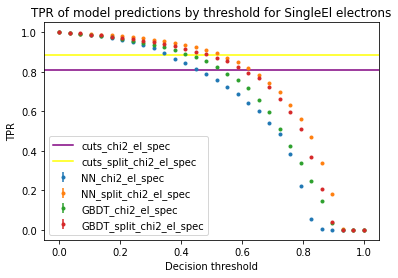

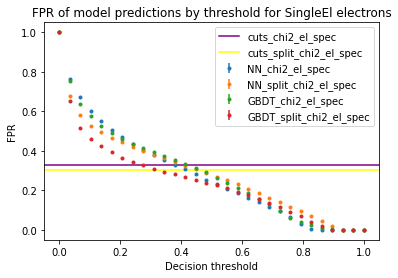

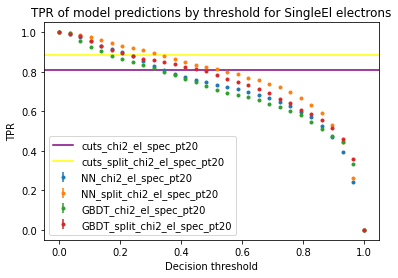

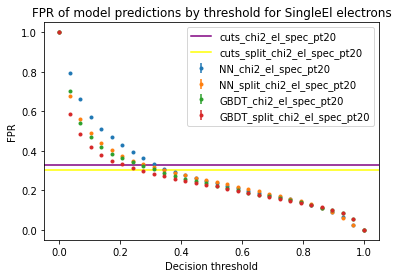

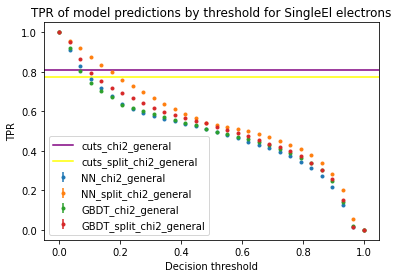

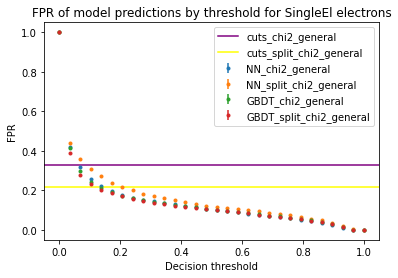

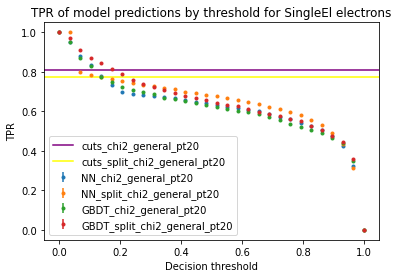

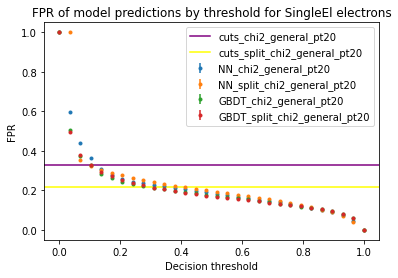

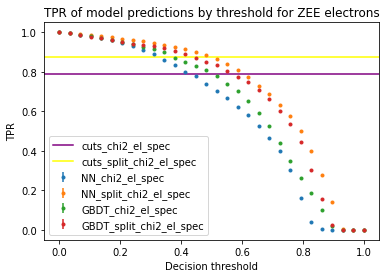

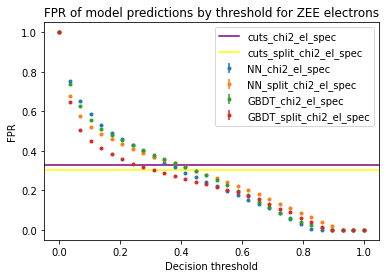

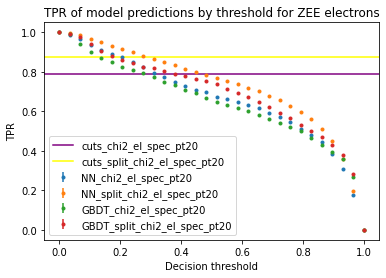

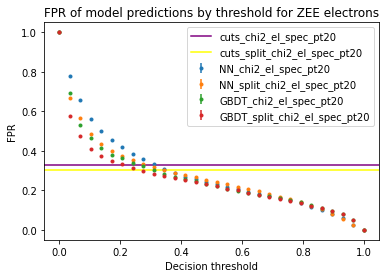

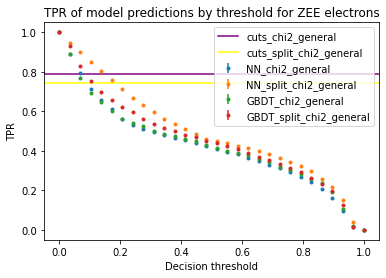

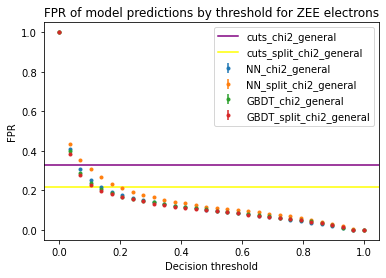

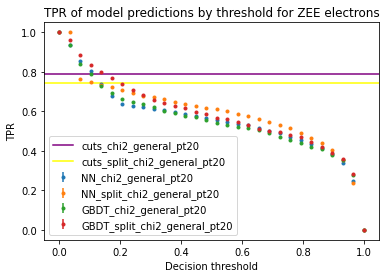

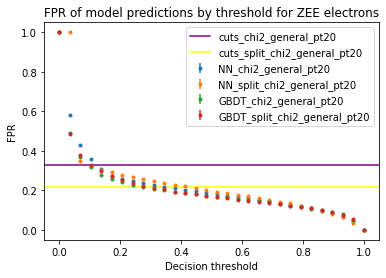

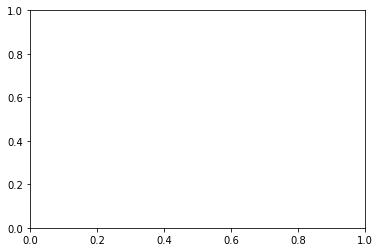

In [45]:
for test_ds, test_ds_name in zip([single_el_test_ds, zee_test_ds], ["SingleEl electrons", "ZEE electrons"]):
                                                    # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets ("el_spec", etc.)
            plot_tpr_fpr_by_threshold(test_ds, test_ds_name, train_dataset_name)

### ROC Curves

Plot the discriminators' paths through TPR/FPR space as the threshold on probablistically predicted labels changes. Also includes the cuts' point in that space.

In [27]:
def plot_rocs(test_ds, train_ds_name, model_set_name, xlims=(0, .5), ylims=(.7, 1)):
    """Takes in a dataset made of equal parts electrons and fakes and
    the model set name (which can also include the model train dataset
    if els_fakes_ds is the single_el_test_ds). Assumes that this dataset
    already has predictions with discriminator keys of the form "NN_{}",
    "GBDT_{}", and "cuts_{}"."""
    
    NN_pred_name = f"NN_{model_set_name}_{train_ds_name}"
    GBDT_pred_name = f"GBDT_{model_set_name}_{train_ds_name}"
    cut_pred_name = f"cuts_{model_set_name}_{train_ds_name}"
    return ndmlplot.plot_rocs(test_ds, [NN_pred_name, GBDT_pred_name], [cut_pred_name], xlims=xlims, ylims=ylims)

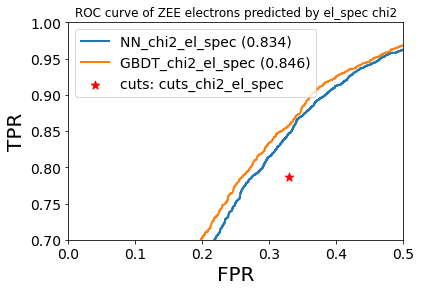

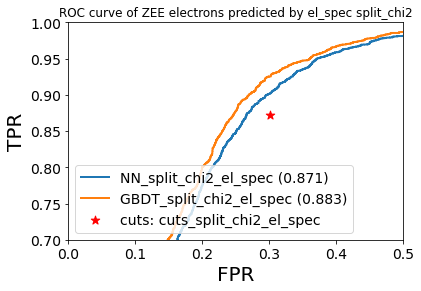

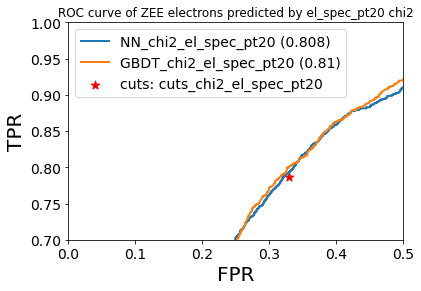

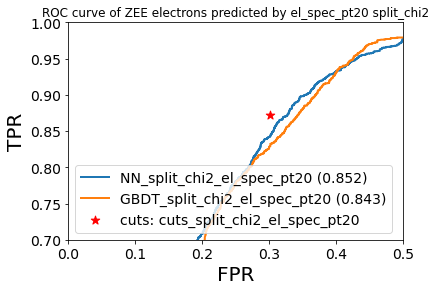

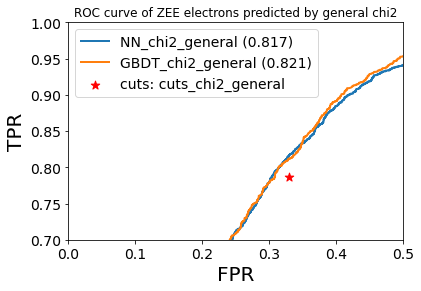

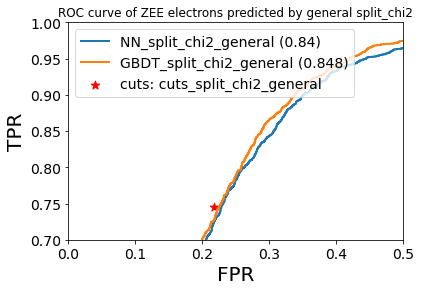

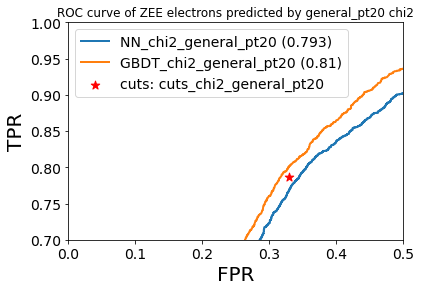

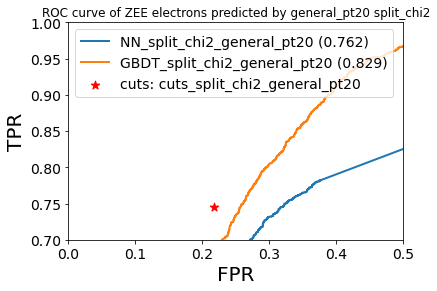

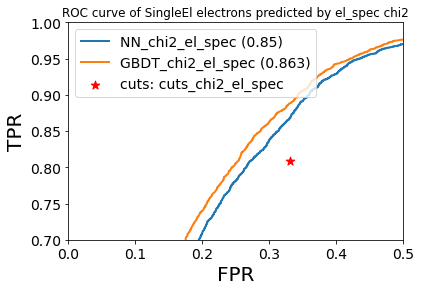

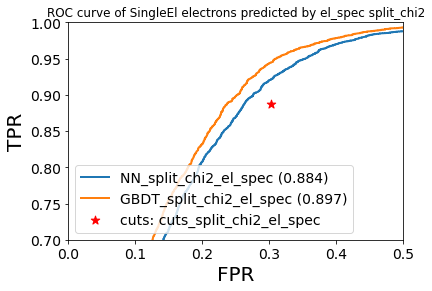

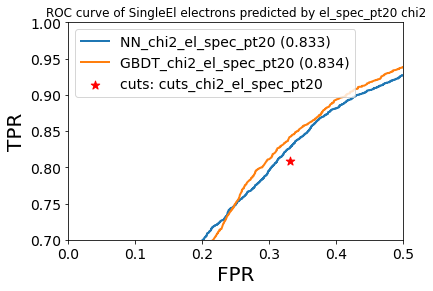

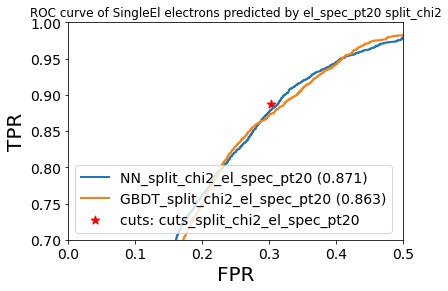

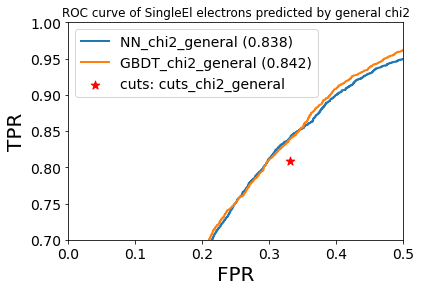

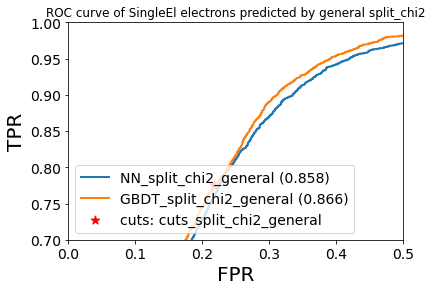

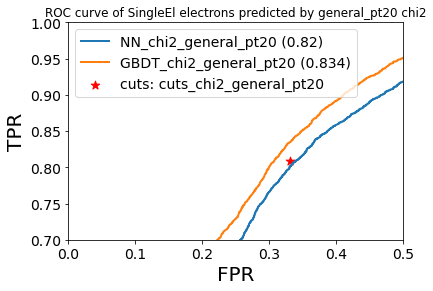

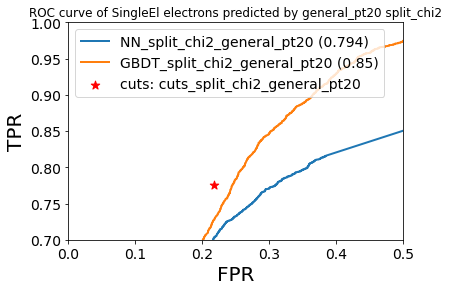

In [28]:
for test_ds, test_ds_name in zip([zee_test_ds, single_el_test_ds], ["ZEE electrons", "SingleEl electrons"]):
                                                    # iterate through our two test datasets
    for train_dataset_name in train_dataset_names:  # iterate through names of trained-on datasets ("el_spec", etc.)
        for model_set_name in model_set_names:      # iterate through model set names ("chi2", "split_chi2")
            ax = plot_rocs(test_ds, train_dataset_name, model_set_name)
            ax.set_title(f"ROC curve of {test_ds_name} predicted by {train_dataset_name} {model_set_name}")

### Particle TPR and FPR by Track Property

Plots TPR and FPR for particles of a particular type for binned values of some track property. The aim of this is to get a sense of how model performance depends upon track properties like pT and eta. Makes plots for both sets of models to compare performance.

In [37]:
def overlay_predictions_by_track_property(test_ds, test_ds_name, train_ds_name,
    model_set_name, pred_comparison, pred_comp_name, binning_prop, bins, threshold):
    """Bin a set of predictions by some track property."""
    
    NN_pred_name = f"NN_{model_set_name}_{train_ds_name}"
    GBDT_pred_name = f"GBDT_{model_set_name}_{train_ds_name}"
    cut_pred_name = f"cuts_{model_set_name}_{train_ds_name}"
    
    pred_names = [NN_pred_name, GBDT_pred_name, cut_pred_name]
    
    ax = gca()
    for pred_name in pred_names:
        ax = ndmlplot.plot_pred_comparison_by_track_property(
                test_ds, pred_name,
                pred_comparison, binning_prop, bins=bins, threshold=threshold,
                legend_id=pred_name, ax=ax)
    for line in ax.get_lines():
        line.set_linestyle("-")
        line.set_drawstyle("steps-mid")
        line.set_marker("")
    ax.set_ylabel(pred_comp_name)
    ax.set_title(f"{pred_comp_name} of model predictions on {test_ds_name} electrons vs. {binning_prop}; threshold of {threshold}")
    ax.legend()
    show()
    cla()

In [38]:
def plot_predictions_by_track_property(test_ds, test_ds_name, train_ds_name, threshold=0.2):
    """A control function for the above 'overlay_predictions_by_track_property'."""
    
    # A dictionary from track properties to bin specifiers
    binning_dict = {"pt": (2, 100, 30)}

    for binning_prop, bins in zip(binning_dict.keys(), binning_dict.values()):  # Iterate through binning props
        for pred_comparison, pred_comp_name in zip(
                [ndmlpred.true_positive_rate, ndmlpred.false_positive_rate],
                ["TPR", "FPR"]):  # Iterate through prediction measurement types
            overlay_predictions_by_track_property(test_ds, test_ds_name, train_ds_name,
                "split_chi2", pred_comparison, pred_comp_name, binning_prop, bins, threshold)
            overlay_predictions_by_track_property(test_ds, test_ds_name, train_ds_name,
                "chi2", pred_comparison, pred_comp_name, binning_prop, bins, threshold)

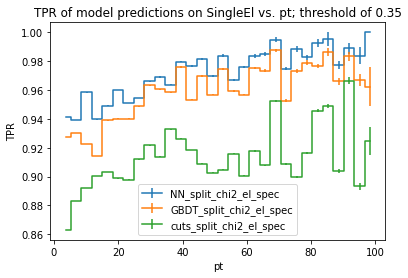

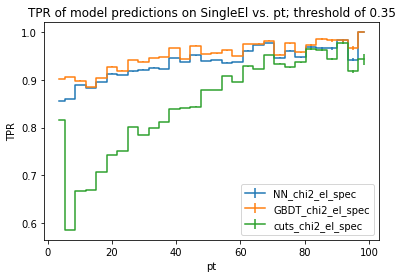

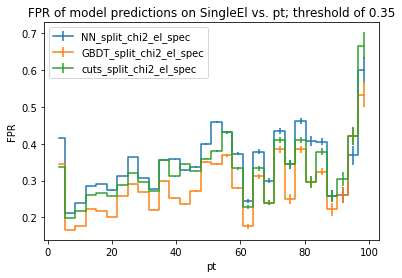

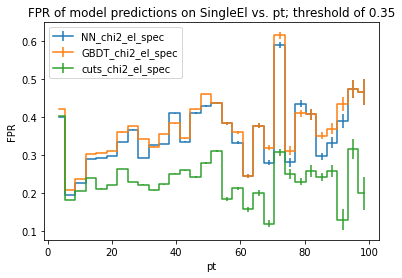

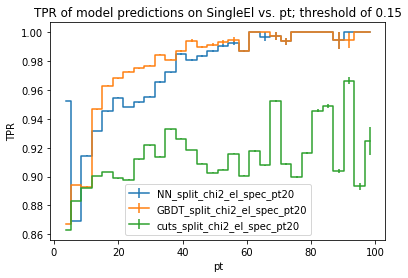

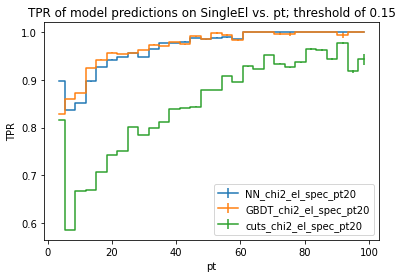

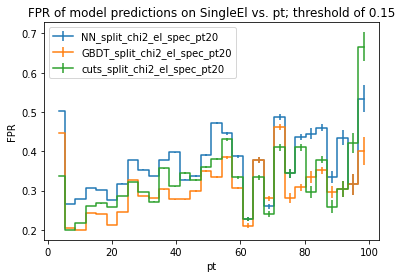

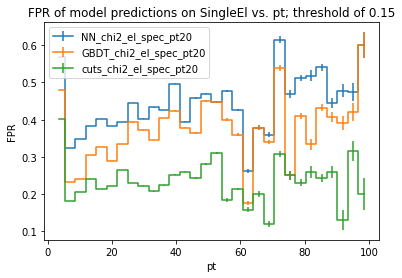

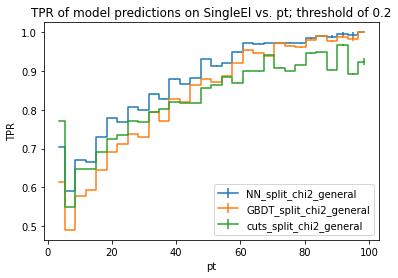

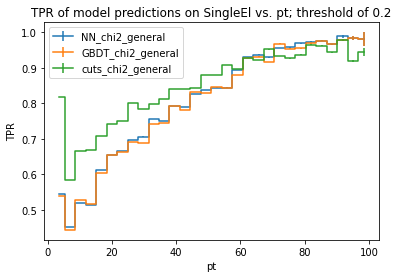

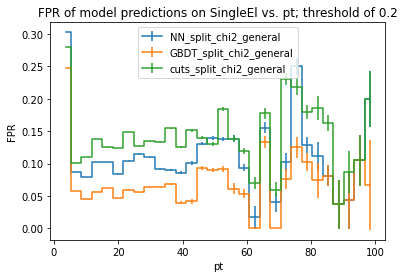

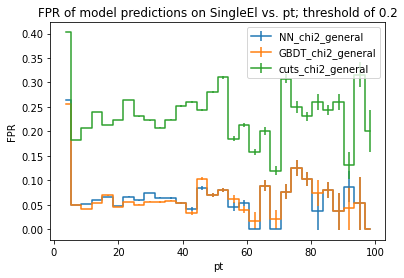

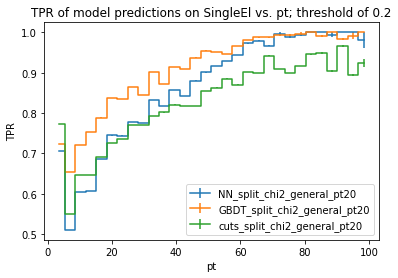

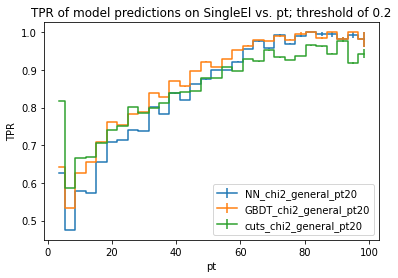

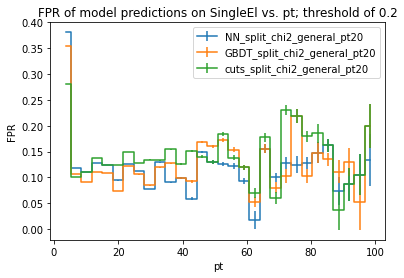

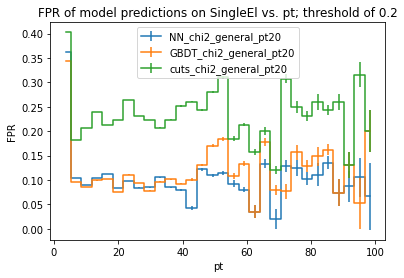

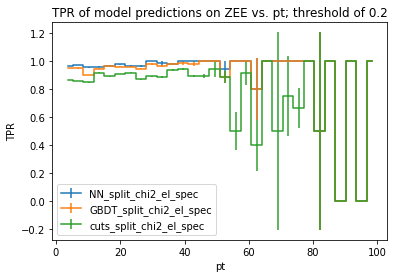

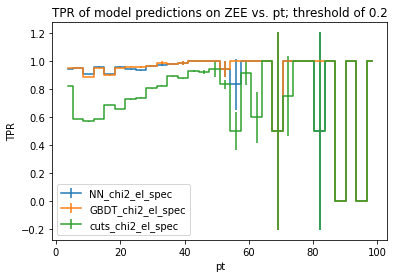

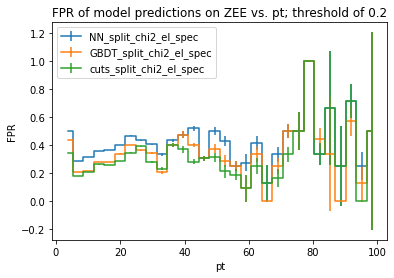

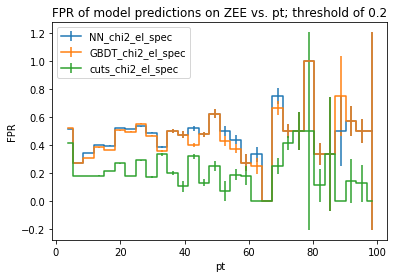

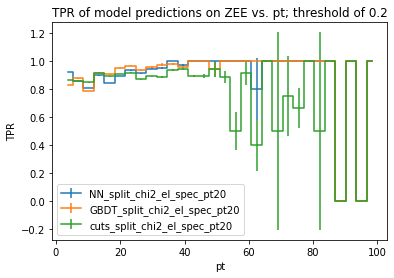

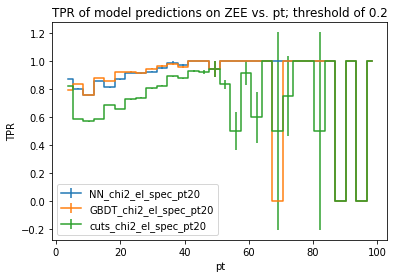

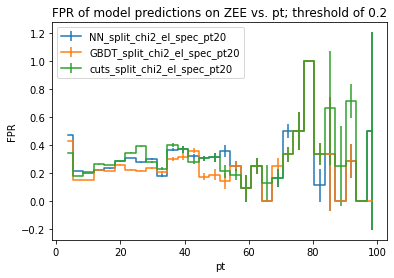

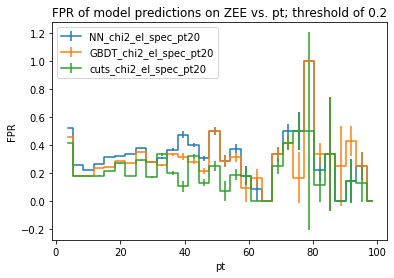

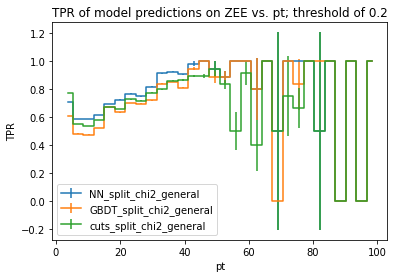

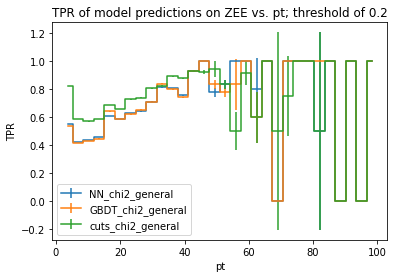

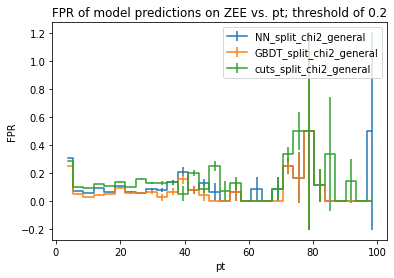

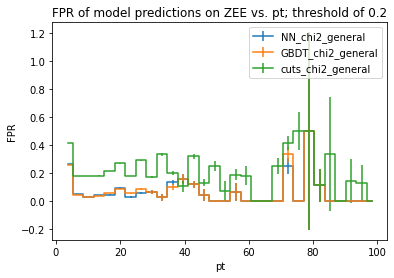

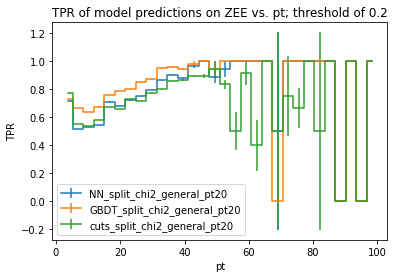

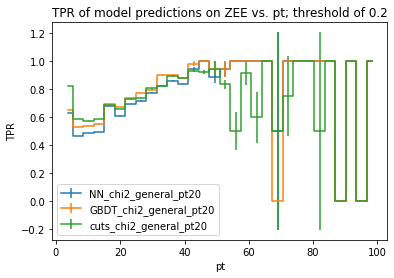

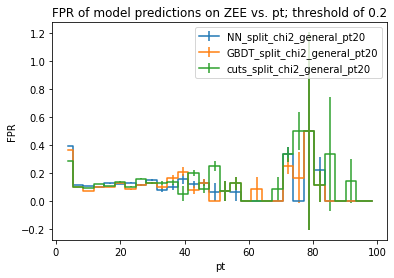

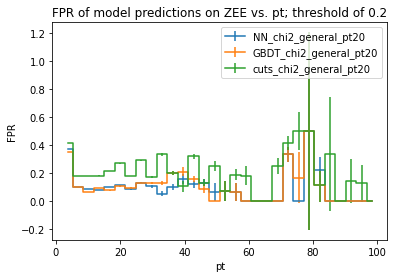

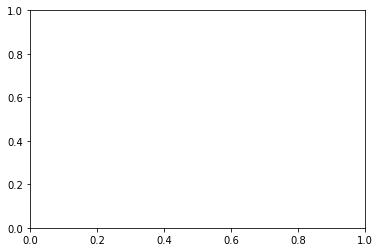

In [44]:
thresholds = {"SingleEl": {"el_spec": .35, "el_spec_pt20": .15, "general": 0.2, "general_pt20": 0.2},
              "ZEE":      {"el_spec": 0.2, "el_spec_pt20": 0.2, "general": 0.2, "general_pt20": 0.2}}

for test_ds, test_ds_name in zip([single_el_test_ds, zee_test_ds], ["SingleEl", "ZEE"]):
                                                    # iterate through our two test datasets
    for train_ds_name in train_dataset_names:  # iterate through names of trained-on datasets ("el_spec", etc.)
        plot_predictions_by_track_property(test_ds, 
                                           test_ds_name, 
                                           train_ds_name, 
                                           thresholds[test_ds_name][train_ds_name])

## Discussion

The goal of this study was to find the best electron discriminator for the track-trigger given a search space that took us over 19 different models.
The search space is repeated below, with the selections in bold.

First question first: **Do models trained on split chi2 variables perform better?**  
Answer: **Yes.**

The area under a ROC curve (AUC) can be taken as a general measure of how well an algorithm performs in a predictive binary classification problem, and here the AUC for both models increases by 3-4% when they are allowed to train on chi2rz and chi2rphi as opposed to the joint chi2.

- *Track properties trained on*: a set of common track properties and [ chi2, **chi2rphi and chi2rz** ].

Next question: **Do the electron-specific models perform better than the general model on electrons?**  
Answer: **Also yes.**

While the general models do perform quite well, restricting training to electron increases the AUC by 2-3% in for all-pT-trained models.

- *Dataset trained on*: [ **electron-specific**, general ].

**Does restricting training to pT >= 20 GeV tracks increase performance on those tracks?**  
Answer: **Yes.**

However, it also reduces performance on tracks with pT below 20 GeV.
Whether a pT cut is placed on training data depends on what is desired out of an electron discriminator.
If more value is placed on tracks of higher pT, some pT cut on training data is encouraged.

- *Train dataset pT range*: ~~[ all pT values, only pT >= 20 GeV ]~~ It depends.

Last question: **Do the models perform better than cuts?**  
Answer: **Yes, for the models we'd want to use.**

Based on the above decisions, the discriminator we'd want to use is electron-specific and split chi2.
In both of those cases, and for pT restricted and unrestricted models, the models outpreform the cut sets, as can be seen in the ROC curves.

- *Discriminator type*: [ cuts, **gradient boosted decision tree**, **neural network** ].

### Future Work

**Hyperparameter optimization**: The [hyperparameters](https://www.jeremyjordan.me/hyperparameter-tuning/) for the models were chosen using Claire Savard's (CU Boulder, graduate student) previous work on machine learning for the track-trigger.
However, her studies focused on trkMET cuts, and so her optimized hyperparameters could be different from those for this study.

**Tracklet seed variable**: Another variable indexed by track is the tracklet seed variable, which has its roots in the track-trigger algorithm (see page 16 of [this slideshow](https://wiki.classe.cornell.edu/pub/People/AndersRyd/170629_Tracklet_AWLC.pdf) for more information).
However, how tracklet seed would be used is a tricky question, as it isn't mappable to the real numbers like pT, eta, or a number of missing moules are.
More thought should be put into it.

**Model Implementation**: This study tested neural networks and gradient boosted decision trees.
Generally, the GBDT was found to slightly outpreform the neural net, though this may change after hyperparameter optimization.
However, more types of models should be tested, both for accuracy and for resource usage on hardware.
Previous work on implementing neural networks in hardware can be found [here](https://indico.cern.ch/event/876306/contributions/3710752/attachments/1974066/3284864/L1T_1_22_20.pdf).

### Conclusion

After searching through a range of discriminators, it was found that the most performant electron discriminator for the track trigger was a machine learning-based model **specifically trained for electrons**, and that **includes in training and testing the new dimensionally restricted chi2 variables chi2rphi and chi2rz**.
pT should be restricted depending.